- Create a good validation schema
- Implement evaluation metric

### Validation Distributions

In [74]:
import pandas as pd
from utility.utils import *
from dataset.validation import *
from utility.plots import *

In [6]:
classes = pd.read_csv('classes.csv')

In [7]:
classes.head()

,filename,foreground,background,is_train
0,d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...,white,black,True
1,4596961c789d3b41916492918797724fe75128239fefc5...,white,black,True
2,b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...,white,black,True
3,831218e6a1a54b23d4be56c5799854e7eb978811b89215...,white,black,True
4,b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...,white,black,True


In [8]:
classes[~classes.is_train].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             1         1
           white              3         3
           yellow             8         8
white      black             53        53

In [9]:
# create new stratified validation set
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, 1)

In [10]:
# distributions seem similar to test
classes[classes.filename.isin([f + '.png' for f in valid_dirs])].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             1         1
           white              4         4
white      black             59        59

In [12]:
# main_path = '../data/ds_bowl_2018/'
# full_path = '../data/ds_bowl_2018/full_data/'
# create_validation_dirs(main_path, full_path, None, train_dirs, valid_dirs)

### Example Metric Implementation

In [13]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation

# Load a single image and its associated masks
id_ = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
file = "../data/ds_bowl_2018/train/{}/images/{}.png".format(id_,id_)
masks = "../data/ds_bowl_2018/train/{}/masks/*.png".format(id_)
image = skimage.io.imread(file)
masks = skimage.io.imread_collection(masks).concatenate()
height, width, _ = image.shape
num_masks = masks.shape[0]

# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1

Text(0.5,1,'Ground truth masks')

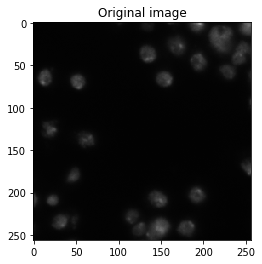

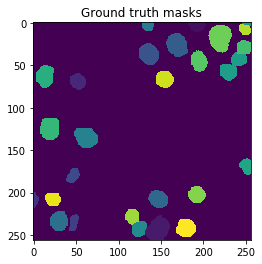

In [14]:
# Show label image
fig = plt.figure()
plt.imshow(image)
plt.title("Original image")
fig = plt.figure()
plt.imshow(labels)
plt.title("Ground truth masks")

In [15]:
# Simulate an imperfect submission
offset = 2 # offset pixels
y_pred = labels[offset:, offset:]
y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")
y_pred[y_pred == 20] = 0 # Remove one object
y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects

/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


Text(0.5,1,'Simulated imperfect submission')

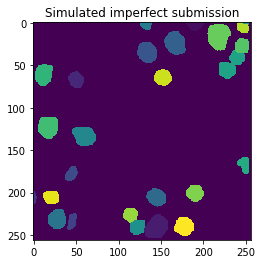

In [16]:
# Show simulated predictions with shifted segmentations
# and 1 missing mask
fig = plt.figure()
plt.imshow(y_pred)
plt.title("Simulated imperfect submission")

In [17]:
# Compute number of objects
true_objects = len(np.unique(labels))-1
pred_objects = len(np.unique(y_pred))-1
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

Number of true objects: 27
Number of predicted objects: 26


In [18]:
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), 
              bins=(true_objects, pred_objects))[0]

In [19]:
# Compute areas (needed for finding the union between all objects)
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

In [20]:
area_true.shape, area_pred.shape

((27, 1), (1, 26))

In [21]:
# Compute union
union = area_true + area_pred - intersection

In [22]:
union[union==0] = 1e-9

In [23]:
iou = intersection / union

In [24]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [25]:
# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Thresh	TP	FP	FN	Prec.
0.500	25	1	2	0.893
0.550	24	2	3	0.828
0.600	22	4	5	0.710
0.650	18	8	9	0.514
0.700	13	13	14	0.325
0.750	5	21	22	0.104
0.800	1	25	26	0.019
0.850	1	25	26	0.019
0.900	1	25	26	0.019
0.950	0	26	27	0.000
AP	-	-	-	0.343


### Metric

In [96]:
def run_length_encode(x):
    bs = np.where(x.T.flatten())[0]

    rle = []
    prev = -2
    for b in bs:
        if (b>prev+1): rle.extend((b + 1, 0))
        rle[-1] += 1
        prev = b

    #https://www.kaggle.com/c/data-science-bowl-2018/discussion/48561#
    if len(rle)!=0 and rle[-1]+rle[-2] == x.size:
        rle[-2] = rle[-2] -1  #print('xxx')

    rle = ' '.join([str(r) for r in rle])
    return rle

def run_length_decode(rle, H, W, fill_value=255):

    mask = np.zeros((H * W), np.uint8)
    rle = np.array([int(s) for s in rle.split(' ')]).reshape(-1, 2)
    for r in rle:
        start = r[0]-1
        end = start + r[1]
        mask[start : end] = fill_value
    mask = mask.reshape(W, H).T # H, W need to swap as transposing.
    return mask



#https://www.kaggle.com/wcukierski/example-metric-implementation
def compute_precision(threshold, iou):
    matches = iou > threshold
    true_positives  = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

def print_precision(precision):

    print('thresh   prec    TP    FP    FN')
    print('---------------------------------')
    for (t, p, tp, fp, fn) in precision:
        print('%0.2f     %0.2f   %3d   %3d   %3d'%(t, p, tp, fp, fn))



def compute_average_precision_for_mask(predict, truth, t_range=np.arange(0.5, 1.0, 0.05)):

    num_truth   = len(np.unique(truth))
    num_predict = len(np.unique(predict))

    # Compute intersection between all objects
    intersection = np.histogram2d(truth.flatten(), predict.flatten(), bins=(num_truth, num_predict))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(truth,   bins = num_truth  )[0]
    area_pred = np.histogram(predict, bins = num_predict)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred,  0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    precision = []
    average_precision = 0
    for t in t_range:
        tp, fp, fn = compute_precision(t, iou)
        p = tp / (tp + fp + fn)
        precision.append((t, p, tp, fp, fn))
        average_precision += p

    average_precision /= len(precision)
    return average_precision, precision


In [97]:
train_labels = pd.read_csv('../data/ds_bowl_2018/csv/stage1_train_labels.csv')

In [98]:
img_id = train_labels.ImageId[0]

In [99]:
img_path = f'../data/ds_bowl_2018/full_data/{img_id}/images/{img_id}.png'
mask_path = f'../data/ds_bowl_2018/full_data/{img_id}/one_mask.png'

(256, 256, 3)

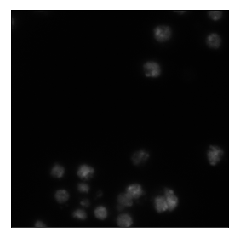

In [100]:
img = open_image(img_path)
show_img(img)
img.shape

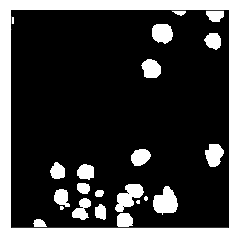

In [101]:
mask = open_image(mask_path)
show_img(mask)

In [102]:
rles = train_labels[train_labels.ImageId == img_id]['EncodedPixels']

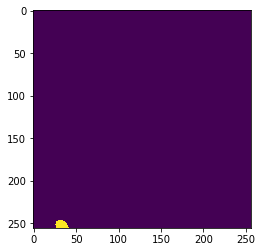

In [109]:
plt.imshow(run_length_decode(rles[0], *img.shape))

In [112]:
# pixel 1 x[1,1] pixel 2 x[2,1]
x = np.array(
    [
    [0,0,0,0,0,0],
    [1,1,1,0,0,0],
    [1,1,1,0,0,0],
    [1,1,1,0,0,0],
    [0,0,0,0,2,2],
    [0,0,0,0,2,2],
    ]
)
x

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 2, 2],
       [0, 0, 0, 0, 2, 2]])

In [117]:
# What if we predict like this
# Our model thougt there are 3 adjacent nuclei
x_pred = np.array(
    [
    [0,0,0,0,0,0],
    [2,2,1,0,0,0],
    [2,2,1,0,0,0],
    [3,3,2,0,0,0],
    [0,0,0,0,4,4],
    [0,0,0,0,4,4],
    ]
)
x_pred

array([[0, 0, 0, 0, 0, 0],
       [2, 2, 1, 0, 0, 0],
       [2, 2, 1, 0, 0, 0],
       [3, 3, 2, 0, 0, 0],
       [0, 0, 0, 0, 4, 4],
       [0, 0, 0, 0, 4, 4]])

In [118]:
pre, _ = compute_average_precision_for_mask(x, x_pred, t_range=np.arange(0.5, 1.0, 0.05))

In [119]:
pre

0.26